In [ ]:
#install these packages

!pip install vtk
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import vtkmodules.all as vtk
from vtkmodules.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import meshio
from scipy.spatial.distance import cdist
from torchvision import datasets, transforms
import random

In [ ]:
#insert here your path where the folder is located

DATASET_PATH = '/content/drive/MyDrive/data_ML4Science'

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(50)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
print(device)

cuda


In [ ]:
fields = {'velocity', 'pressure'}

basis_space, sv_space, Nh_space, nmodes_space = dict(), dict(), dict(), dict()
basis_time, sv_time, Nh_time, nmodes_time = dict(), dict(), dict(), dict()
nmodes = dict()
for field in fields:
    basis_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_basis.npy'))  # spatial basis
    sv_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_sv.npy'))  # singular values in space
    Nh_space[field], nmodes_space[field] = basis_space[field].shape  # number of FOM and ROM unknowns in space
    basis_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_basis.npy'))  # temporal basis
    sv_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_sv.npy'))  # singular values in time
    Nh_time[field], nmodes_time[field] = basis_time[field].shape  # number of FOM and ROM unknowns in time
    nmodes[field] = nmodes_space[field] * nmodes_time[field]  # total dimension of the reduced basis

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
N_supr_space = basis_space['pressure'].shape[1] + 66  # number of extra bases in space for the velocity
N_supr_time = 5  # number of extra bases in time for the velocity

# STORE ORIGINAL NUMBER OF VELOCITY MODES IN THE DICTIONARY
nmodes_space['velocity_full'] = nmodes_space['velocity']
nmodes_time['velocity_full'] = nmodes_time['velocity']
nmodes['velocity_full'] = nmodes['velocity']

# UPDATE THE NUMBER OF VELOCITY MODES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
nmodes_space['velocity'] -= N_supr_space
nmodes_time['velocity'] -= N_supr_time
nmodes['velocity'] = nmodes_space['velocity'] * nmodes_time['velocity']

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
basis_space['velocity'] = basis_space['velocity'][:, :nmodes_space['velocity']]
basis_time['velocity'] = basis_time['velocity'][:, :nmodes_time['velocity']]

# LOAD NORMED BASIS MATRICES IN SPACE (needed for projections)
basis_space_normed = dict()
#norm = dict()
for field in fields:
    #norm[field] = load_npz(os.path.join('dataset', 'norms', f'norm_{field}.npz'))
    #basis_space_normed[field] = norm[field].dot(basis_space[field])
    #np.save(os.path.join('dataset', 'basis', field, 'basis_space_normed.npy'), basis_space_normed[field])
    basis_space_normed[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'basis_space_normed.npy'))

##################################################################
def project(sol, normed_basis_space, basis_time):
    """ Project a full-order solution in space-time."""
    return (normed_basis_space.T.dot(sol)).dot(basis_time) # !! REMARK: here we need the normed basis in space !!

def expand(sol, basis_space, basis_time):
    """ Expand a reduced-order solution in space-time."""
    return (basis_space.dot(sol)).dot(basis_time.T)

##################################################################

In [ ]:
#load solutions ( output )

n_snaps = None  # change to a number if you want to load only a subset of snapshots
_sol = np.load(os.path.join(DATASET_PATH, 'RB_data', 'solutions.npy'))[:n_snaps]

solutions = dict()

# velocity reduced solutions (with and without supremizers and stabilizers)
solutions['velocity_full'] = np.reshape(_sol[:, :nmodes['velocity_full']],
                                        (-1, nmodes_space['velocity_full'], nmodes_time['velocity_full']))
solutions['velocity'] = solutions['velocity_full'][:, :nmodes_space['velocity'], :nmodes_time['velocity']]

# pressure reduced solutions
solutions['pressure'] = np.reshape(_sol[:, :nmodes['pressure']],
                                   (-1, nmodes_space['pressure'], nmodes_time['pressure']))

In [ ]:
#Load parameters ( input )

params = np.load(os.path.join(DATASET_PATH, 'RB_data', 'parameters.npy'))
params = np.delete(params, 2, axis=1)

In [ ]:
#convert from numpy to tensor
solutions['pressure']= torch.tensor(solutions['pressure'], dtype=torch.float32)
solutions['velocity']= torch.tensor(solutions['velocity'], dtype=torch.float32)
params = torch.tensor(params, dtype=torch.float32)

In [ ]:
solutions['velocity'].shape

torch.Size([1950, 39, 16])

In [ ]:
class Fluid_Dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets =  targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):

        input = self.inputs[idx]
        output = self.targets[idx]
        return input, output


In [ ]:
#split in train and test and standardize

N_data=params.shape[0]
indices = torch.randperm(N_data)
ratio_data=0.75
train_size = int(ratio_data * N_data)
train_indices = indices[:train_size]
test_indices=indices[train_size:]

train_params=params[train_indices]
test_params=params[test_indices]

# # # # # # # # # # mean_params=torch.mean(train_params,dim=0)
# # # # # # # # # # std_params=torch.std(train_params,dim=0)
# # # # # # # # # # train_params=(train_params-mean_params)/std_params
# # # # # # # # # # test_params=(test_params-mean_params)/std_params
###################################################
min_params=torch.min(params,dim=0).values
max_params=torch.max(params,dim=0).values
train_params=(train_params-min_params)/(max_params-min_params)
test_params=(test_params-min_params)/(max_params-min_params)
###################################################

train_vel=solutions['velocity'][train_indices]

test_vel=solutions['velocity'][test_indices]

train_press=solutions['pressure'][train_indices]
test_press=solutions['pressure'][test_indices]
#print(train_vel[0,0,:])

In [ ]:
#Since the encoder input is the output of the model, we also standardise the output (velocity)

# # # # # # # # # # vel_space_max = torch.max(train_vel, dim= 0).values
# # # # # # # # # # vel_space_min = torch.min(train_vel, dim=0).values
# # # # # # # # # # train_vel = (train_vel - vel_space_min) / (vel_space_max - vel_space_min)
# # # # # # # # # # test_vel =(test_vel - vel_space_min ) / (vel_space_max -vel_space_min)
###################################################
vel_space_max = torch.max(solutions["velocity"], dim= 0).values
vel_space_min = torch.min(solutions["velocity"], dim=0).values
train_vel = (train_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)
test_vel =(test_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)
###################################################
#print(train_vel[0,0,:])



In [ ]:
#MODEL

class MLP_autoencoder(torch.nn.Module):
    def __init__(self, activation, L_enc_dec, L_l=4, dim_reduced=128, K=256, dim_1=39, dim_2=16):

        """
          MLP + fully connected autoencoder model

          Args:
              activation: activation function ("relu" or "gelu")
              L_enc_dec: int, number layers of the encoder (=number of layers of the decoder)
              L_l: int, number of layers in the mlp
              dim_reduced : int,  the size to which we want to reduce
              K: int, depth of layers in MLP
              dim_1: int,  first dimension  of the output matrix (39)
              dim_2: int, second dimension of the output matrix (16)


          """

        super(MLP_autoencoder, self).__init__()

        #the depth of each layer (i.e., the number of neurons per layer) decrease proportionally, r is the reduction factor between consecutive layers
        r = (dim_reduced / (dim_1*dim_2)) ** (1 / L_enc_dec)

        # dims contains the values of the depth of each layer of the encoder
        dims = [round(dim_1*dim_2 * (r ** i)) for i in range(L_enc_dec)] + [dim_reduced]

        self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU

        #MLP
        self.mlp = torch.nn.Sequential(
            *[layer for i in range(L_l) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                self.activation(),
            ]],
            torch.nn.Linear(K, dim_reduced), #(batch_size, K) -> (batch_size, dim_reduced)
            torch.nn.LayerNorm(dim_reduced),
            self.activation()
        )

        #ENCODER
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(), #(batch_size, 39, 16) -> (batch_size,624)

            *[layer for i in range(L_enc_dec) for layer in [
                torch.nn.Linear(dims[i], dims[i+1]),
                torch.nn.LayerNorm(dims[i+1]),
                self.activation()
            ]],
             # dim output = (batch_size, dim_reduced)
        )

        #DECODER
        self.decoder = torch.nn.Sequential(

            *[layer for i in range(L_enc_dec-1) for layer in [
                torch.nn.Linear(dims[L_enc_dec-i], dims[L_enc_dec-i-1]),
                torch.nn.LayerNorm(dims[L_enc_dec-i-1]),
                self.activation()
            ]],
            torch.nn.Linear(dims[1], dims[0]), # dim output = (batch_size, dim_1 * dim_2 )
            #torch.nn.Sigmoid(),
            torch.nn.Unflatten(1, (dim_1, dim_2)), # dim_output = (batch_size, dim_1, dim_2)
        )

    def forward(self, par, out):

        Z1 = self.mlp(par)  # (batch_size, dim_reduced)
        Z2 = self.encoder(out)  # (batch_size, dim_reduced)
        Z3 = self.decoder(Z2) # (batch_size, dim_1, dim_2)
        return Z1, Z2, Z3

    def predict(self, par):
        Z = self.mlp(par)  # (batch_size, dim_reduced)
        Z = self.decoder(Z)  # (batch_size,  dim_1, dim_2)
        return Z

In [ ]:
#TRAIN
print(device)
vel_space_min=vel_space_min.to(device)
vel_space_max=vel_space_max.to(device)

def train_encoder_decoder_epoch(model, device, train_loader, optimizer, epoch, criterion, weights=[1,1]):
    model.train()

    loss_history = [] #list with train loss for each batch
    loss_history_enc_dec = [] #list with train loss relative to encoder-decoder for each batch
    loss_history_mlp_encoder = [] #list with train loss relative to mlp-encoder for each batch

    for batch_idx, (data, target) in enumerate(train_loader):


        data=data.to(device)
        target=target.to(device)

        Z1, Z2, Z3 = model.forward(data, target)

        assert Z3.shape == target.shape
        assert Z1.shape == Z2.shape


        # # # # # # # # # # target=target*(vel_space_max - vel_space_min)+vel_space_min   #denormalize target and output
        # # # # # # # # # # Z3=Z3*(vel_space_max - vel_space_min)+vel_space_min
        #############################

        target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        Z3=Z3*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        ##############################

        Z3_flattened = Z3.flatten(1)   #flatter target and output to compute MSE
        target_fattened = target.flatten(1)

        loss_enc_dec = criterion(target_fattened, Z3_flattened)   #loss encoder_decoder
        loss_mlp_encoder = criterion(Z1, Z2) #loss mlp_encoder


        loss =  weights[0] * loss_enc_dec + weights[1] * loss_mlp_encoder #the  loss is the sum of the 2 losses

        optimizer.zero_grad()  # Zero the gradients

        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history_enc_dec.append(loss_enc_dec.item())
        loss_history_mlp_encoder.append(loss_mlp_encoder.item())
        loss_history.append(loss.item())

    return loss_history, loss_history_enc_dec, loss_history_mlp_encoder


@torch.no_grad()
def validate(model, device, val_loader, criterion, weights):
    model.eval()
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model.predict(data)    #compute output
####################################################################################
        # # # # # # # # assert output.shape == target.shape


        # # # # # # # # # # # # # # # # # # output=output*(vel_space_max - vel_space_min)+ vel_space_min     #denormalize target and output
        # # # # # # # # # # # # # # # # # # target=target*(vel_space_max - vel_space_min)+ vel_space_min
        # # # # # # # # ##############################
        # # # # # # # # output=output*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        # # # # # # # # target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        # # # # # # # # ##############################

        # # # # # # # # output_flattened = output.flatten(1)         #flatten target and output to compute MSE
        # # # # # # # # target_flattened = target.flatten(1)

        # # # # # # # # test_loss += criterion(output_flattened, target_flattened).item() * len(data)  #compute MSE
#######################################################################################
        Z1, Z2, Z3 = model.forward(data, target)

        assert Z3.shape == target.shape
        assert Z1.shape == Z2.shape

        target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        Z3=Z3*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min

        Z3_flattened = Z3.flatten(1)   #flatter target and output to compute MSE
        target_fattened = target.flatten(1)

        loss_enc_dec = criterion(target_fattened, Z3_flattened)   #loss encoder_decoder
        loss_mlp_encoder = criterion(Z1, Z2) #loss mlp_encoder


        loss =  weights[0] * loss_enc_dec + weights[1] * loss_mlp_encoder #the  loss is the sum of the 2 losses

        test_loss += loss.item() * len(data)  #compute MSE

        output = model.predict(data)    #compute output

        output=output*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
#############################################################################################

        test_rel_loss += ((torch.norm((output-target).view(output.shape[0], -1), dim=1, p=2)/torch.norm((target).view(output.shape[0], -1), dim=1, p=2)).sum()).item()

    test_loss /= len(val_loader.dataset)
    test_rel_loss /= len(val_loader.dataset)

    return test_loss,test_rel_loss


def run_vel_training_encoder_decoder(model_encoder_decoder,num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel, device="cuda", weights = [1,1]):


    train_vel_DataSet = Fluid_Dataset(train_params, train_vel)
    test_vel_DataSet = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_vel_DataSet,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        test_vel_DataSet,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model_encoder_decoder = model_encoder_decoder.to(device=device)

    optimizer  = torch.optim.Adam(
        model_encoder_decoder.parameters(),
        lr=lr,
        ########################weight_decay = 1e-4
        weight_decay = 1e-6
    )
    #################################################
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.75, patience=25
    # )
    #################################################
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    criterion = torch.nn.functional.mse_loss

    # ===== Train Model =====
    train_loss_history = []
    train_loss_enc_dec_history = []
    train_loss_mlp_enc_history = []
    val_loss_history = []
    val_rel_loss_history = []


    for epoch in range(1, num_epochs + 1):

        train_loss, train_loss_enc_dec, train_loss_mlp_enc = train_encoder_decoder_epoch(
           model_encoder_decoder, device, train_loader, optimizer, epoch, criterion,weights
        )
        #print("LOSS_ENC: ", sum(trai_loss_enc_dec)/len(trai_loss_enc_dec), " LOSS_MLP: ", sum(train_loss_mlp_enc)/len(train_loss_mlp_enc))
        train_loss_history.extend(train_loss)
        train_loss_enc_dec_history.extend(train_loss_enc_dec)
        train_loss_mlp_enc_history.extend(train_loss_mlp_enc)

        val_loss,val_rel_loss = validate(model_encoder_decoder, device, val_loader, criterion, weights)
        val_loss_history.append(val_loss)
        val_rel_loss_history.append(val_rel_loss)
        scheduler.step(val_loss)

    return model_encoder_decoder, train_loss_history,  val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_mlp_enc_history


cuda


In [ ]:
def plot(ax, train_loss_history, val_loss_history, val_rel_loss_history, num_epochs):

    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    ax.semilogy(t_train, train_loss_history, label="Train loss")
    ax.semilogy(t_val, val_loss_history, label="Val loss")
    ax.semilogy(t_val, val_rel_loss_history, label="Vali rel error")
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss / error")

**Hyperparameter optimization**

as the parameters to be tuned are many, we start iterating on learning rate and number of epochs to see the best values.
As the optimum learning rate and number of epochs for good training should not vary too much with a small change in the architecture, we expect that the good values found for the fixed architecture will also perform well with a slight change in the architecture in the following steps.

to do this, we train the model by varying the learning rate, keeping the number of epochs large, so as to see which learning rates allow for better learning and after how many epochs the model settles

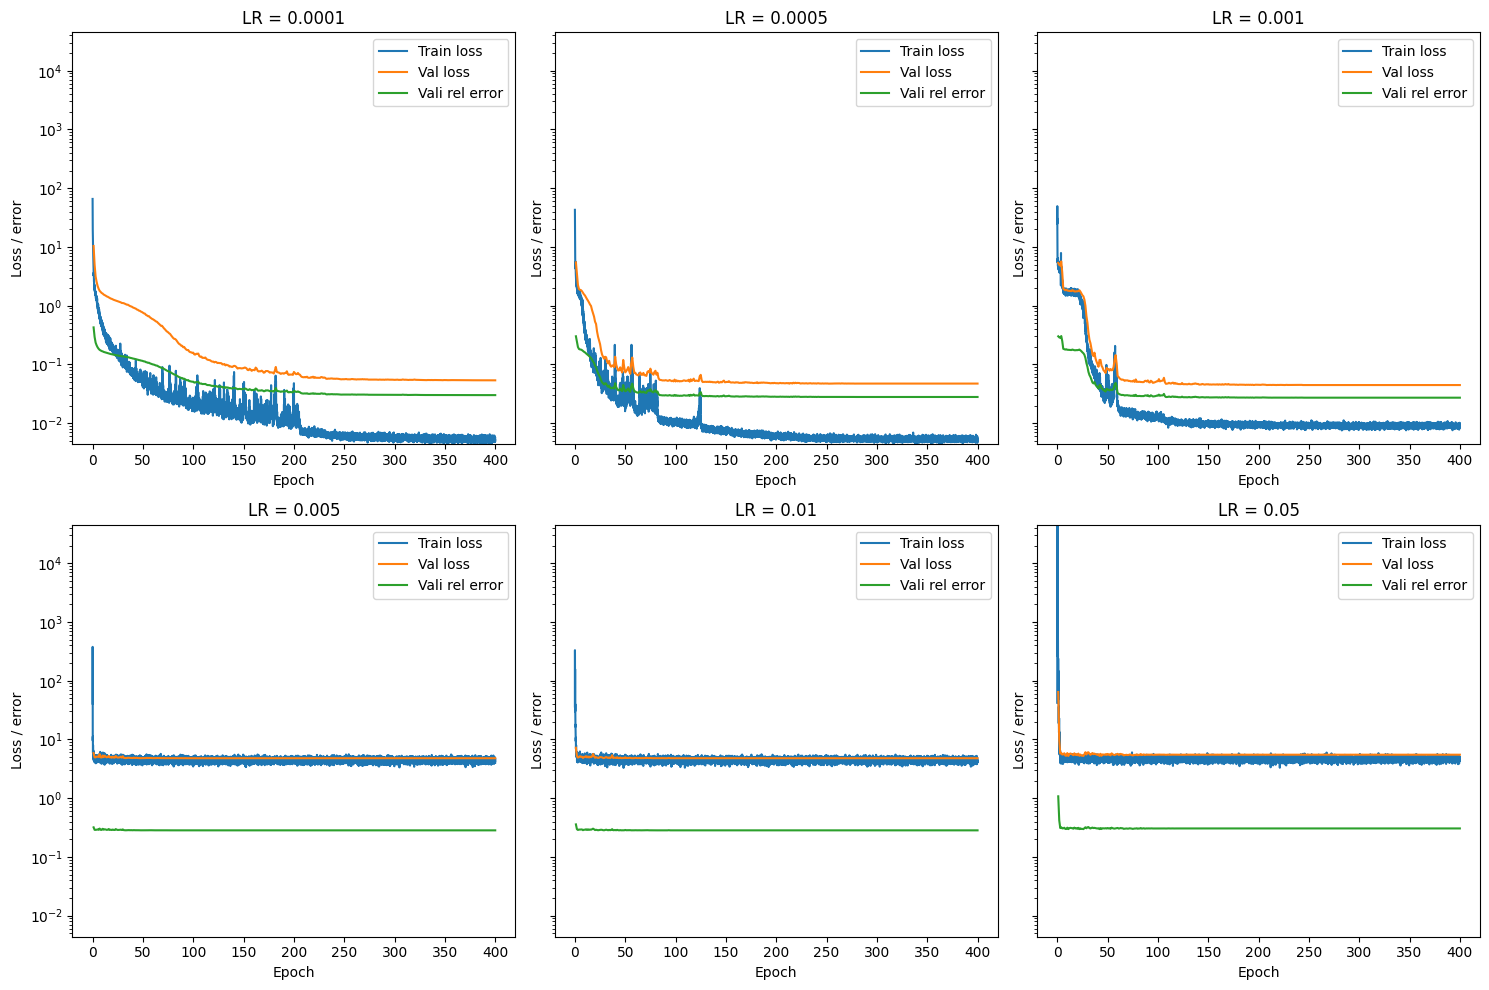

In [ ]:
#define a standard structure for the model architecture
L_enc_dec=4
dim_reduced = 128
batch_size=64
num_epochs=400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#values of learning rates values on which we want to tune
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

#or each value of lr, add to the lists the last value of train_loss_history, val_loss_history and val_rel_err_history (i.e values corresponding to epoch = num_epoch)
last_values_train_loss = []
last_values_val_loss = []
last_values_val_rel_error = []

#we need these values to give a limit to the y-axis of the graphs
y_min = float('inf')
y_max = -float('inf')

for idx, lr in enumerate(lr_values):


        #train the model
        model_trained, train_loss_history, val_loss_history, val_rel_loss_history,  train_loss_enc_dec_history, train_loss_mlp_enc_history = run_vel_training_encoder_decoder(
        MLP_autoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=L_enc_dec,),
        num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel, device, weights = [1,1]
    )
        #extract values corresponding to epoch = num_epoch (last values of the lists)
        last_values_train_loss.append(train_loss_history[-1])
        last_values_val_loss.append(val_loss_history[-1])
        last_values_val_rel_error.append(val_rel_loss_history[-1])


        row = idx // 3
        col = idx % 3

        # Plot the graphs
        plot(ax[row, col], train_loss_history, val_loss_history, val_rel_loss_history, num_epochs)
        ax[row, col].set_title(f"LR = {lr}")
        y_max = max(y_max, max(np.max(train_loss_history), np.max(val_loss_history), np.max(val_rel_loss_history)))
        y_min = min(y_min, min(np.min(train_loss_history), np.min(val_loss_history), np.min(val_rel_loss_history)))


for i in range(2):
    for j in range(3):
        ax[i, j].set_ylim(y_min, y_max)


plt.tight_layout()
plt.show()

In [ ]:
for idx, lr in enumerate(lr_values):
    print(f"LR = {lr}, Train_loss = {last_values_train_loss[idx]:.4f}, Test_loss = {last_values_val_loss[idx]:.4f}, test_relative_error = {last_values_val_rel_error[idx]:.4f}")

LR = 0.0001, Train_loss = 0.0051, Test_loss = 0.0542, test_relative_error = 0.0301
LR = 0.0005, Train_loss = 0.0055, Test_loss = 0.0463, test_relative_error = 0.0277
LR = 0.001, Train_loss = 0.0088, Test_loss = 0.0435, test_relative_error = 0.0268
LR = 0.005, Train_loss = 1.5177, Test_loss = 1.7117, test_relative_error = 0.1726
LR = 0.01, Train_loss = 4.2203, Test_loss = 4.7913, test_relative_error = 0.2836
LR = 0.05, Train_loss = 1.7302, Test_loss = 4.8634, test_relative_error = 0.2849


as we can see from the graph the learning rate that lead to the smaller training error is ...
and the number of epoch required for the model to establish is ...

In [ ]:
best_lr = 0.001
# # # # # # # best_num_epochs=400
###############################
best_num_epochs=300
batch_size=64
###############################

now let's tune the parameter of the autoencoder i.e the number of hidden layers and dim reduced. we don't consider the depth of layers as a hyperparameter beacause each layer progressively reduces the dimensionality of the data in a proportional manner, maintaining a consistent scaling factor between layers (see the model above)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


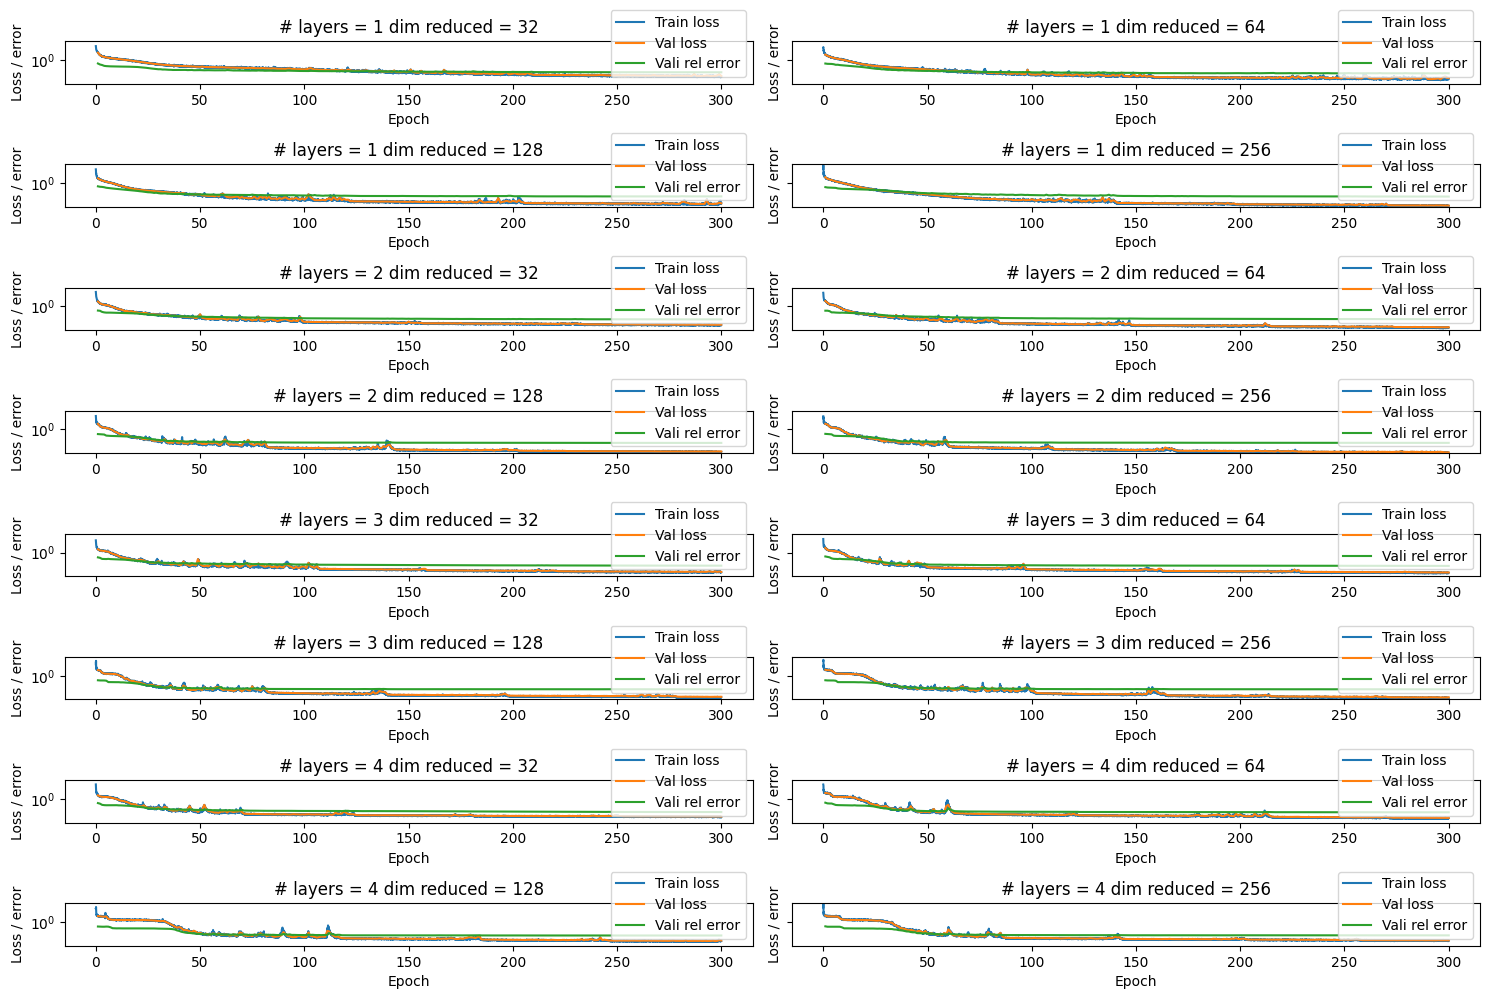

In [ ]:
l_values = [1, 2, 3, 4]
dim_reduced_list = [32, 64, 128, 256]

#or each value of l nad dim_reduced, add to the matrixs the last value of train_loss_history, val_loss_history and val_rel_err_history (i.e values corresponding to epoch = num_epoch)
last_value_train_loss_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
last_value_val_loss_matrix= np.zeros((len(l_values), len(dim_reduced_list)))
last_value_val_rel_loss_matrix = np.zeros((len(l_values), len(dim_reduced_list)))

fig, ax = plt.subplots(8, 2, figsize=(15, 10), sharey=True)
y_min = float('inf')
y_max = -float('inf')

#GRID SEARCH
Counter=0
for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):

        model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_mlp_enc_history = run_vel_training_encoder_decoder(
        MLP_autoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=l,),
        best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, weights=[1,1]
    )

        subplot_index = idx_l * len(dim_reduced_list) + idx_dim_reduced
        row = subplot_index // 2
        col = subplot_index % 2

        last_value_train_loss = train_loss_history[-1]
        last_value_val_loss = val_loss_history[-1]
        last_value_val_rel_loss = val_rel_loss_history[-1]

        last_value_train_loss_matrix[idx_l, idx_dim_reduced] = last_value_train_loss
        last_value_val_loss_matrix[idx_l, idx_dim_reduced] = last_value_val_loss
        last_value_val_rel_loss_matrix[idx_l, idx_dim_reduced] = last_value_val_rel_loss


        #plot the graphs
        plot(ax[row, col], train_loss_history, val_loss_history, val_rel_loss_history, best_num_epochs)
        ax[row, col].set_title(f"# layers = {l} dim reduced = {dim_reduced}", )
        y_max = max(y_max, max(np.max(train_loss_history), np.max(val_loss_history), np.max(val_rel_loss_history)))
        y_min = min(y_min, min(np.min(train_loss_history), np.min(val_loss_history), np.min(val_rel_loss_history)))
        print(Counter)
        Counter+=1


for i in range(8):
    for j in range(2):
        ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
       print(f"Layers = {l}, dim_reduced = {dim_reduced}, Train_loss = {last_value_train_loss_matrix[idx_l,idx_dim_reduced ]:.4f}, Test_loss = {last_value_val_loss_matrix[idx_l,idx_dim_reduced ]:.4f}, test_relative_error = {last_value_val_rel_loss_matrix[idx_l,idx_dim_reduced ]:.4f}")

In [ ]:
for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
       print(f"Layers = {l}, dim_reduced = {dim_reduced}, Train_loss = {last_value_train_loss_matrix[idx_l,idx_dim_reduced ]:.4f}, Test_loss = {last_value_val_loss_matrix[idx_l,idx_dim_reduced ]:.4f}, test_relative_error = {last_value_val_rel_loss_matrix[idx_l,idx_dim_reduced ]:.4f}")

Layers = 1, dim_reduced = 32, Train_loss = 0.0100, Test_loss = 0.0133, test_relative_error = 0.0361
Layers = 1, dim_reduced = 64, Train_loss = 0.0062, Test_loss = 0.0075, test_relative_error = 0.0274
Layers = 1, dim_reduced = 128, Train_loss = 0.0043, Test_loss = 0.0042, test_relative_error = 0.0278
Layers = 1, dim_reduced = 256, Train_loss = 0.0021, Test_loss = 0.0023, test_relative_error = 0.0264
Layers = 2, dim_reduced = 32, Train_loss = 0.0060, Test_loss = 0.0068, test_relative_error = 0.0291
Layers = 2, dim_reduced = 64, Train_loss = 0.0029, Test_loss = 0.0033, test_relative_error = 0.0306
Layers = 2, dim_reduced = 128, Train_loss = 0.0023, Test_loss = 0.0025, test_relative_error = 0.0258
Layers = 2, dim_reduced = 256, Train_loss = 0.0016, Test_loss = 0.0019, test_relative_error = 0.0260
Layers = 3, dim_reduced = 32, Train_loss = 0.0047, Test_loss = 0.0052, test_relative_error = 0.0285
Layers = 3, dim_reduced = 64, Train_loss = 0.0039, Test_loss = 0.0045, test_relative_error = 0.0

In [ ]:
best_index=last_value_val_rel_loss_matrix.argmin()
best_row = best_index // 4
best_col = best_index % 4

best_L_enc_dec= l_values[best_row]
best_dim_reduced = dim_reduced_list[best_col]
print(f"best_L_enc_dec = {best_L_enc_dec}, best_dim_reduced = {best_dim_reduced}")

best_L_enc_dec = 3, best_dim_reduced = 128


In [ ]:
best_L_enc_dec=3
best_dim_reduced=128
best_num_epochs=300
best_lr=0.001
batch_size=64

since the train_loss is computed as the sum of two losses, now we observe how much they differ

In [ ]:
#Training the best one again (MAGARI NON NECESSARIO)
model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_mlp_enc_history = run_vel_training_encoder_decoder(
        MLP_autoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_c=best_L_enc_dec,),
        best_num_epochs, best_lr, batch_size, device, weights=[1,1]
    )

n_train = len(train_loss_history)
t_train = best_num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

plt.semilogy(t_train, train_loss_enc_dec_history, label="Train loss autoencoder")
plt.semilogy(t_train, train_loss_mlp_enc_history, label="train  loss mlp_encoder")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")


let's now try to tune the weights we give to the loss.

we note that the loss relative to the encoder decoder is approximately 10 times greater than the loss relative to the output of the encoder and the output of the mlp

In [ ]:
#TUNE THE WEIGHTS TO SEE IF YOU CAN ACHIEVE BETTER RESULTS !!

0
1
2
3


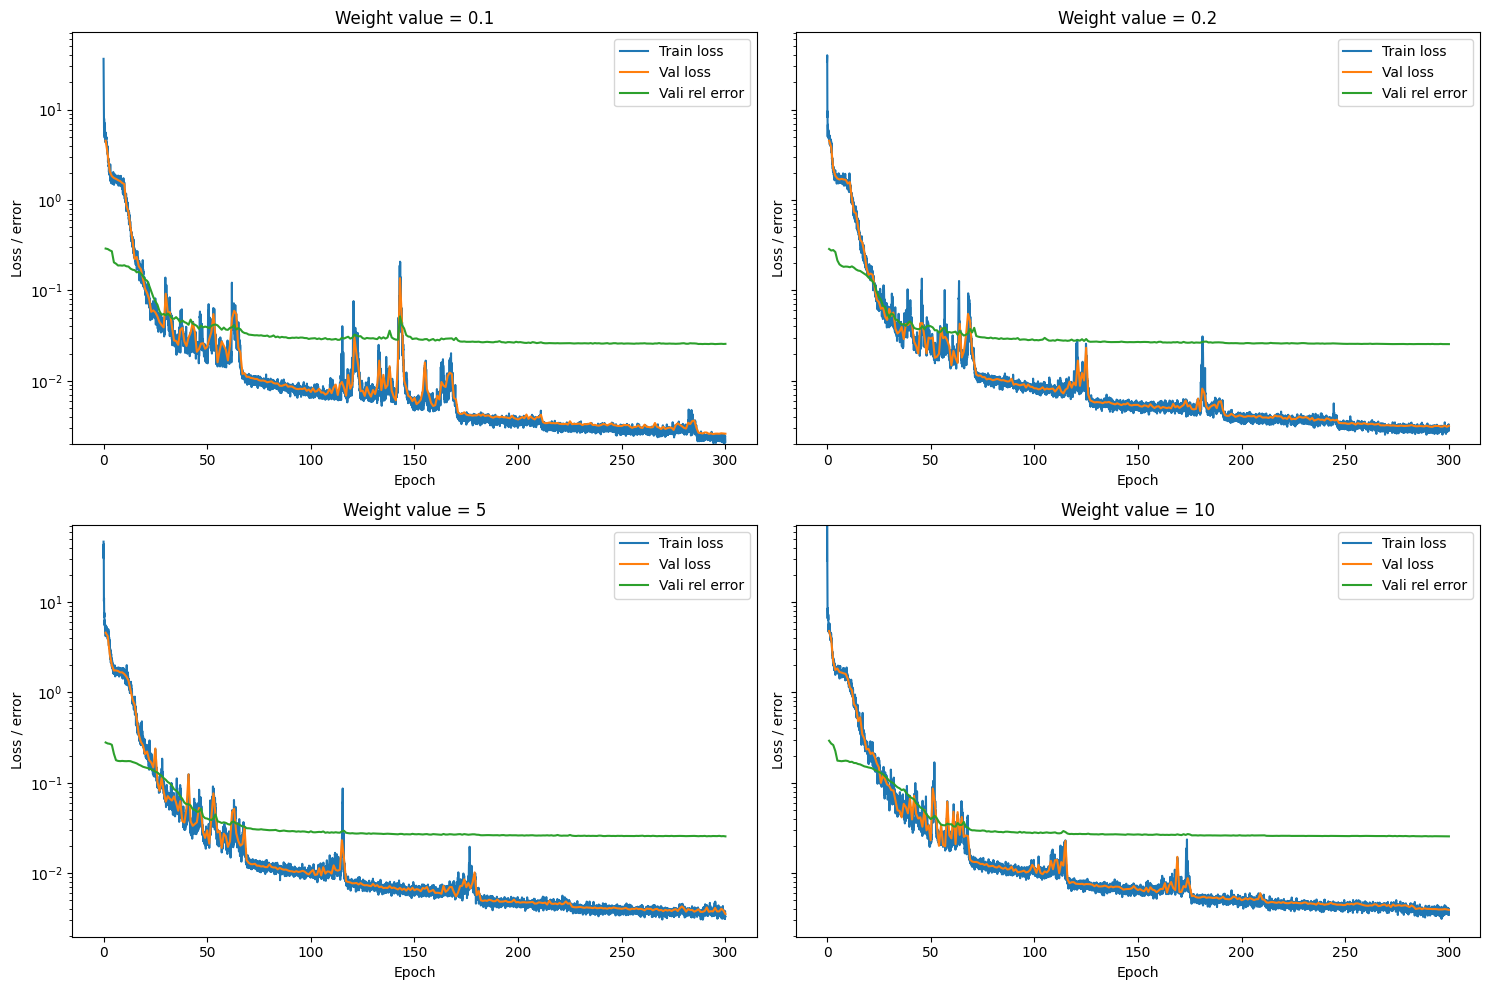

Weight value = 0.1, Train_loss = 0.0021, Test_loss = 0.0026, test_relative_error = 0.0256
Weight value = 0.2, Train_loss = 0.0028, Test_loss = 0.0032, test_relative_error = 0.0254
Weight value = 5, Train_loss = 0.0033, Test_loss = 0.0035, test_relative_error = 0.0256
Weight value = 10, Train_loss = 0.0035, Test_loss = 0.0039, test_relative_error = 0.0256


In [ ]:
# w_values=[5,10,50,100]
w_values=[1/10,1/5,5,10]

#or each value of l nad dim_reduced, add to the matrixs the last value of train_loss_history, val_loss_history and val_rel_err_history (i.e values corresponding to epoch = num_epoch)
last_value_train_loss_w = np.zeros((len(w_values),))
last_value_val_loss_w= np.zeros((len(w_values),))
last_value_val_rel_w = np.zeros((len(w_values),))

fig, ax = plt.subplots(2, 2 , figsize=(15, 10), sharey=True)
y_min = float('inf')
y_max = -float('inf')

#GRID SEARCH
Counter=0
for idx_w, w_value in enumerate(w_values):

      model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_mlp_enc_history = run_vel_training_encoder_decoder(
      MLP_autoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec,),
      best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, weights=[1,w_value]
  )

      last_value_train_loss = train_loss_history[-1]
      last_value_val_loss = val_loss_history[-1]
      last_value_val_rel_loss = val_rel_loss_history[-1]

      last_value_train_loss_w[idx_w] = last_value_train_loss
      last_value_val_loss_w[idx_w] = last_value_val_loss
      last_value_val_rel_w[idx_w] = last_value_val_rel_loss

      row = idx_w // 2
      col = idx_w % 2

      #plot the graphs
      plot(ax[row,col], train_loss_history, val_loss_history, val_rel_loss_history, best_num_epochs)
      ax[row, col].set_title(f"Weight value = {w_value}")
      y_max = max(y_max, max(np.max(train_loss_history), np.max(val_loss_history), np.max(val_rel_loss_history)))
      y_min = min(y_min, min(np.min(train_loss_history), np.min(val_loss_history), np.min(val_rel_loss_history)))
      print(Counter)
      Counter+=1


for i in range(2):
  for j in range(2):
      ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

for idx_w, w_value in enumerate(w_values):
    print(f"Weight value = {w_value}, Train_loss = {last_value_train_loss_w[idx_w]:.4f}, Test_loss = {last_value_val_loss_w[idx_w]:.4f}, test_relative_error = {last_value_val_rel_w[idx_w]:.4f}")

# TRAINING THE THE AUTOENCODER AND MLP SEPARATELY

let's train the 2 structures separately, first the autoencoder, so that it allows good compression of the output. then let's train the mlp taking the encoder outputs.

the hyperparameters used in this model are the best hyperparamaters we have found above


*   best lr
*   best dim_reduced
*   best L_enc_dec






In [ ]:
#model of autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self, activation, L_enc_dec,  dim_reduced=128, dim_1=39, dim_2=16):

        """
         fully connected autoencoder model

          Args:
              activation: activation function ("relu" or "gelu")
              L_enc_dec: int, number layers of the encoder (=number of layers of the decoder)
              dim_reduced : int,  the size to which we want to reduce
              dim_1: int,  first dimension  of the output matrix (39)
              dim_2: int, second dimension of the output matrix (16)

          """

        super(Autoencoder, self).__init__()

        #the depth of each layer (i.e., the number of neurons per layer) decrease proportionally, r is the reduction factor between consecutive layers
        r = (dim_reduced / (dim_1*dim_2)) ** (1 / L_enc_dec)

        # dims contains the values of the depth of each layer of the encoder
        dims = [round(dim_1*dim_2 * (r ** i)) for i in range(L_enc_dec)] + [dim_reduced]

        self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU

        # input (batch_size, dim_1 , dim_2) = (batch_size, 39 , 16)
        self.encoder = torch.nn.Sequential(

            torch.nn.Flatten(), #(batch_size, 39, 16) -> (batch_size,624)

            *[layer for i in range(L_enc_dec) for layer in [
                torch.nn.Linear(dims[i], dims[i+1]),
                torch.nn.LayerNorm(dims[i+1]),
                self.activation()

            ]],
             # dim output = (batch_size, dim_reduced)

        )

        self.decoder = torch.nn.Sequential(

            *[layer for i in range(L_enc_dec-1) for layer in [
                torch.nn.Linear(dims[L_enc_dec-i], dims[L_enc_dec-i-1]),
                torch.nn.LayerNorm(dims[L_enc_dec-i-1]),
                self.activation()

            ]],
            torch.nn.Linear(dims[1], dims[0]), # dim output = (batch_size, dim_1 * dim_2 )
            #torch.nn.Sigmoid(),
            torch.nn.Unflatten(1, (dim_1, dim_2)), # dim_output = (batch_size, dim_1, dim_2)

        )



    def forward(self, out):

         # (batch_size, dim_reduced)
        Z1 = self.encoder(out)  # (batch_size, dim_reduced)
        Z2 = self.decoder(Z1) # (batch_size, dim_1, dim_2)

        return Z1, Z2

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, L=4, K=256, dim_reduced=128 ,activation="gelu"):

      super(MLP, self).__init__()

      self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU
      self.mlp = torch.nn.Sequential(
            *[layer for i in range(L) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                self.activation(),
            ]],
            torch.nn.Linear(K, dim_reduced), #(batch_size, K) -> (batch_size, dim_reduced)
            torch.nn.LayerNorm(dim_reduced),
            self.activation()
        )
    def forward(self, par):
        Z = self.mlp(par)  # (batch_size, dim_reduced)
        return Z



In [ ]:
#vel_space_min=vel_space_min.to(device)
#vel_space_max=vel_space_max.to(device)

#TRAIN

def train_autoencoder_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []


    for batch_idx, (data, target) in enumerate(train_loader):


        data=data.to(device) #params
        target=target.to(device) #output (input of the model)

        output_encoder, output_decoder = model.forward(target)

        assert output_decoder.shape == target.shape


        # # # # # # # # target=target*(vel_space_max - vel_space_min)+vel_space_min             #denormalize
        # # # # # # # # output_decoder=output_decoder*(vel_space_max - vel_space_min)+vel_space_min
        target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        output_decoder=output_decoder*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min

        output_decoder_flattened = output_decoder.flatten(1)
        target_fattened = target.flatten(1)

        #compute loss
        loss = criterion(output_decoder_flattened, target_fattened)


        optimizer.zero_grad()  # Zero the gradients

        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history.append(loss.item())

    return loss_history


@torch.no_grad()
def validate_autoencoder(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0

    for data, target in val_loader:

        data, target = data.to(device), target.to(device)
        output_encoder, output_decoder = model.forward(target)
        assert output_decoder.shape == target.shape


        # # # # # # # # target=target*(vel_space_max - vel_space_min)+vel_space_min             #denormalize
        # # # # # # # # output_decoder=output_decoder*(vel_space_max - vel_space_min)+vel_space_min
        target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        output_decoder=output_decoder*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min


        output_flattened = output_decoder.flatten(1)
        target_flattened = target.flatten(1)
        test_loss += criterion(output_flattened, target_flattened).item() * len(data)


    test_loss /= len(val_loader.dataset)

    return test_loss


def run_vel_training_autoencoder(model_autoencoder,num_epochs, lr, batch_size, device="cuda"):


    train_vel_DataSet = Fluid_Dataset(train_params, train_vel)
    test_vel_DataSet = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_vel_DataSet,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        test_vel_DataSet,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model_autoencoder = model_autoencoder.to(device=device)



    optimizer  = torch.optim.Adam(
        model_autoencoder.parameters(),
        lr=lr,
        #######################weight_decay = 1e-4
        weight_decay = 1e-6
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    criterion = torch.nn.functional.mse_loss
    # ===== Train Model =====
    train_loss_history = []

    val_loss_history = []


    for epoch in range(1, num_epochs + 1):

        train_loss = train_autoencoder_epoch(
           model_autoencoder, device, train_loader, optimizer, epoch, criterion
        )
        #print("LOSS_ENC: ", sum(trai_loss_enc_dec)/len(trai_loss_enc_dec), " LOSS_MLP: ", sum(train_loss_mlp_enc)/len(train_loss_mlp_enc))
        train_loss_history.extend(train_loss)


        val_loss= validate_autoencoder(model_autoencoder, device, val_loader, criterion)
        val_loss_history.append(val_loss)

        scheduler.step(val_loss)


    return model_autoencoder, train_loss_history,  val_loss_history

In [ ]:
# Plot the graph

L_enc_dec = best_L_enc_dec # change it with best_L_enc_dec
num_epochs=500 #change it to 400 FORSE 600!!!!!!!!!!!!!!!
lr=best_lr # change it with best_lr
batch_size=64
dim_reduced=best_dim_reduced # change it with best_dim_reduced

model_trained, train_loss_history, val_loss_history = run_vel_training_autoencoder(
        Autoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=L_enc_dec),
        num_epochs, lr, batch_size, device
    )



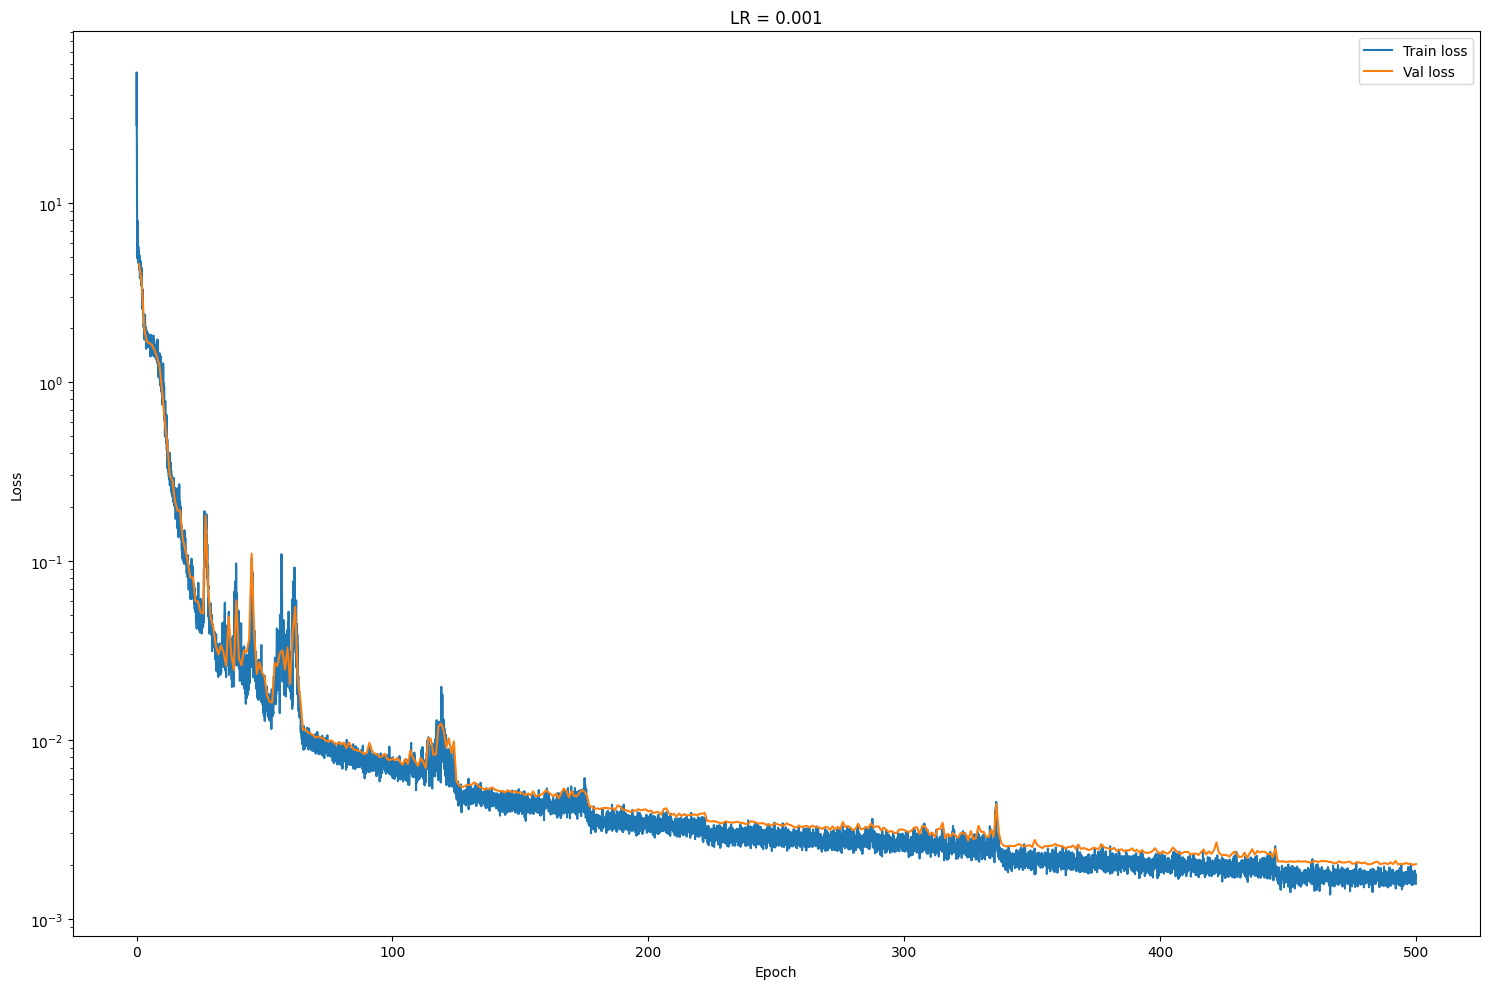

In [ ]:
n_train = len(train_loss_history)
t_train = num_epochs * np.arange(n_train) / n_train  ######SUPERFLUO?????
t_val = np.arange(1, num_epochs + 1)

fig, ax = plt.subplots(figsize=(15, 10), sharey=True)
ax.semilogy(t_train, train_loss_history, label="Train loss")
ax.semilogy(t_val, val_loss_history, label="Val loss")

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title(f"LR = {lr}")
plt.tight_layout()
plt.show()

In [ ]:
print(val_loss_history[-1])

0.002019288018345833


now that we have trained the autoencoder, we can train the mlp


In [ ]:

#DA CAMBIAREEEEEEEEEEEE

def train_mlp(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    accuracy_history = []

    for batch_idx, (data, target) in enumerate(train_loader):


        data=data.to(device)
        target=target.to(device)

        Z = model.forward(data)


        model_trained.eval()
        # output =  model_trained.decoder(Z) #output of decoder
        with torch.no_grad():
          output =  model_trained.encoder(target) #output of encoder

        # assert target.shape == output.shape

        # # # # # output = output * (vel_space_max - vel_space_min) + vel_space_min
        # # # # # target = target * (vel_space_max - vel_space_min) + vel_space_min
        # # # # # output_flattened = output.flatten(1)
        # # # # # target_flattened = target.flatten(1)
        # # # # # loss= criterion(output_flattened, target_flattened)

        loss= criterion(output, Z)

        optimizer.zero_grad()  # Zero the gradients

        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history.append(loss.item())

    return loss_history


@torch.no_grad()
def validate_mlp(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:

        data, target = data.to(device), target.to(device)
        Z = model.forward(data)

        model_trained.eval()
        output =  model_trained.encoder(target)


        # assert output.shape == target.shape

        # output = output * (vel_space_max - vel_space_min) + vel_space_min
        # target = target * (vel_space_max - vel_space_min) + vel_space_min


        # output_flattened = output.flatten(1)
        # target_flattened = target.flatten(1)

        test_loss += criterion(output, Z).item() * len(data)
        # test_rel_loss += ((torch.norm((output-target).view(output.shape[0], -1), dim=1, p=2)/torch.norm((target).view(output.shape[0], -1), dim=1, p=2)).sum()).item()
    test_loss /= len(val_loader.dataset)
    # test_rel_loss /= len(val_loader.dataset)

    # return test_loss, test_rel_loss
    return test_loss

def run_vel_training_mlp(model_mlp,num_epochs, lr, batch_size, device="cuda"):


    train_vel_DataSet = Fluid_Dataset(train_params, train_vel)
    test_vel_DataSet = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_vel_DataSet,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        test_vel_DataSet,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model_mlp = model_mlp.to(device=device)


    optimizer  = torch.optim.Adam(
        model_mlp.parameters(),
        lr=lr,
        # weight_decay = 1e-4
        weight_decay = 1e-6
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    criterion = torch.nn.functional.mse_loss

    # ===== Train Model =====
    train_loss_history = []
    val_loss_history = []
    # val_rel_loss_history = []


    for epoch in range(1, num_epochs + 1):

        train_loss = train_mlp(
           model_mlp, device, train_loader, optimizer, epoch, criterion
        )

        train_loss_history.extend(train_loss)


        # val_loss, test_rel_loss= validate_mlp(model_mlp, device, val_loader, criterion)
        val_loss= validate_mlp(model_mlp, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        # val_rel_loss_history.append(test_rel_loss)
        scheduler.step(val_loss)


    # return model_mlp, train_loss_history,  val_loss_history, val_rel_loss_history
    return model_mlp, train_loss_history,  val_loss_history

In [ ]:
#train MLP

num_epochs=400 #change it to 400
lr=best_lr # change it with best_lr
batch_size=64
dim_reduced=best_dim_reduced # change it with best_dim_reduced

# model_trained_MLP, train_loss_history, val_loss_history, val_rel_loss_history = run_vel_training_mlp(
    #     MLP(dim_reduced=dim_reduced),
    #     num_epochs, lr, batch_size, device
    # )

model_trained_MLP, train_loss_history, val_loss_history= run_vel_training_mlp(
        MLP(dim_reduced=dim_reduced),
        num_epochs, lr, batch_size, device
    )


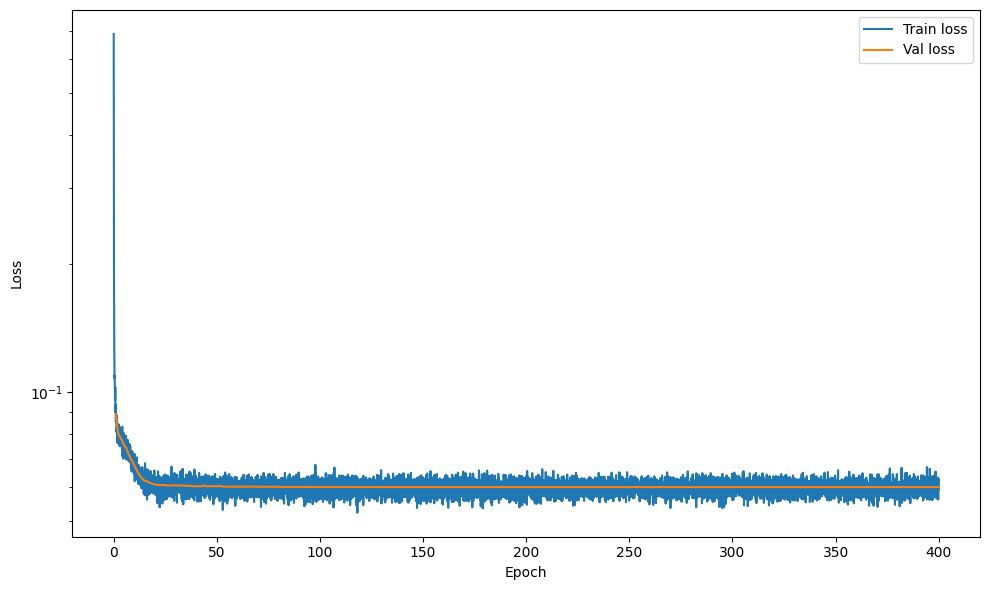

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
n_train = len(train_loss_history)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)
# plot(ax, train_loss_history, val_loss_history, val_rel_loss_history, num_epochs)
ax.semilogy(t_train, train_loss_history, label="Train loss")
ax.semilogy(t_val, val_loss_history, label="Val loss")

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.tight_layout()

In [ ]:
# val_rel_loss_history[-1]

0.02806191662183175

In [ ]:
#Performance Evaluation of Sequential Training
model_trained_MLP.eval()
model_trained.eval()

err_rel=0
with torch.no_grad():
  for (param, vel) in zip(test_params, test_vel):

    param=param.unsqueeze(dim=0)
    param=param.to(device)

    vel=vel.unsqueeze(dim=0)
    vel=vel.to(device)

    vel_reduced_predict=model_trained_MLP(param)
    vel_predict=model_trained.decoder(vel_reduced_predict)

    vel_predict=vel_predict.squeeze(dim=0)
    vel=vel.squeeze(dim=0)

    vel_predict=vel_predict*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
    vel=vel*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
    err_rel+=torch.norm((vel_predict-vel), p=2)/torch.norm(vel, p=2)

  err_rel=err_rel/len(test_params)
  print("The validation test relative error for the sequential training is: ", err_rel)


The validation test relative error for the sequential training is:  tensor(0.1571, device='cuda:0')


# CONVOLUTIONAL LAYERS IN AUTOENCODER

we have seen that a model with a full connected autoencoder works well.
now we try with an autoencoder with convolutional layers.

In [ ]:
#NEW MODEL

class MLP_ConvAutoencoder(torch.nn.Module):
    def __init__(self, activation, K_comb, L_c, L_l, dim_1=39, dim_2=16, dim_reduced=128, K=256):

        """
        MLP + autoencoder model, assume that the convectional layers are reduced in size by a stride =2 to reduce the number of parameters to be tuned

        Args:
            activation: activation function ("relu" or "gelu")
            K_comb: ndarray, two-dimensional array with the number of rows equal to the number of convolutional layers and  3 columns,
                    indicating the kernel size, stride, padding relative to that particular convolutional layer
            L_c: int, number of convolutional layers
            dim_1: int,  first dimension  of the output matrix (39)
            dim_2: int, second dimension of the output matrix (16)
            dim_reduced : int,  the size to which we want to reduce

        """
        super(MLP_ConvAutoencoder, self).__init__()

        #ensure for each layer kernel_size, stride and padding are specified
        assert len(K_comb) == L_c

        assert ((L_c>=1) and (L_c<=3))



        self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU

        #compute the dimension of the output of the decoder and the dimension of the output of each convolutional layers, based
        #on the number of convolutional layers

        if L_c == 1:
            dim_post_encoder = 4864
            tuple_dec=[(32,19,8),(39,16)]
        elif L_c == 2:
            dim_post_encoder = 2304
            tuple_dec=[(64,9,4),(19,8),(39,16)]
        elif L_c == 3:
            dim_post_encoder = 1024
            tuple_dec=[(128,4,2),(9,4),(19,8),(39,16)]


        #MLP

        self.mlp = torch.nn.Sequential(
            *[layer for i in range(4) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                torch.nn.ReLU(),
            ]],
            torch.nn.Linear(K, dim_reduced), #(batch_size, K) -> (batch_size, dim_reduced)
            torch.nn.LayerNorm(dim_reduced),
            self.activation()
        )



        # Encoder

        #input:  (batch_size x 1 x 39 x 16)
        #output:  (batch_size, dim_reduced)

        self.encoder = torch.nn.Sequential(
            *[layer for i in range(L_c) for layer in [
                torch.nn.Conv2d(1 if i == 0 else 2**(i-1)*32, 2**(i)*32, kernel_size=K_comb[i][0], stride=K_comb[i][1], padding=K_comb[i][2]),
                torch.nn.BatchNorm2d(2**(i)*32),
                self.activation(),

            ]],
            torch.nn.Flatten(),
            *[layer for i in range(L_l) for layer in [
                torch.nn.Linear(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1), dim_reduced*(L_l-i)),
                torch.nn.LayerNorm(dim_reduced*(L_l-i)),
                self.activation()

            ]]
        )

        # Decoder

        #input:   (batch_size, dim_reduced)
        #output:  (batch_siz, 1, 39, 16)

        self.decoder = torch.nn.Sequential(
            *[layer for i in range(L_l-1,-1,-1) for layer in [
                torch.nn.Linear(dim_reduced*(L_l-i), dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                torch.nn.LayerNorm(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                self.activation()
            ]],
            torch.nn.Unflatten(1, tuple_dec[0]),
            *[layer for i in range(L_c-1) for layer in [
                 torch.nn.ConvTranspose2d(2**(L_c-i-1)*32, 2**(L_c-i-2)*32, kernel_size=K_comb[L_c-i-1][0], stride=K_comb[L_c-i-1][1], padding=K_comb[L_c-i-1][2], output_padding=(1,0)),
                 torch.nn.BatchNorm2d(2**(L_c-i-2)*32),
                self.activation(),
            ]],

            torch.nn.ConvTranspose2d(32, 1, kernel_size=K_comb[0][0], stride=K_comb[0][1], padding=K_comb[0][2],  output_padding=(1,0)),
            #torch.nn.Sigmoid()
        )



    def forward(self, par, out):
        Z1 = self.mlp(par)  # (batch_size, dim_reduced)

        out_squeezed = out.unsqueeze(1) #(batch_size x 39 x 16) -> #(batch_size x 1 x 39 x 16)

        # print(out_squeezed.shape)
        Z2 = self.encoder(out_squeezed)  # (batch_size, dim_reduced)

        Z3 = self.decoder(Z2) # (batch_siz, 1, dim_1, dim_2)
        Z3=Z3.squeeze(1)  # (batch_siz, dim_1, dim_2)

        return Z1, Z2, Z3

    def predict(self, par):
        Z = self.mlp(par)  # (dim_1_reduced * dim_2_reduced)
        Z = self.decoder(Z)  # (batch_size, 1, dim_1, dim_2)
        Z=Z.squeeze(1)
        return Z

Since the model works with convolutional layers with stride = 2, which halves the height and width of the inputs to each layer, we consider valid the k_combs that satisfy this criterion

examples: [4,2,1] , [6,2,2], [2,2,0], [8,2,3] ...

In [ ]:

activation="gelu" #"relu" o "gelu"

K_comb=[[6,2,2],[6,2,2],[6,2,2]] #o K_comb=[5,1,2]
L_c=3  #1,2, o 3
L_l=2  #1,2, o 3

batch_size=64
num_epochs=400
lr=0.0001
#device=torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_trained, train_loss_history,  val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_mlp_enc_history = run_vel_training_encoder_decoder(MLP_ConvAutoencoder(activation, K_comb, L_c, L_l,  dim_reduced=128,),num_epochs, lr, batch_size, device)




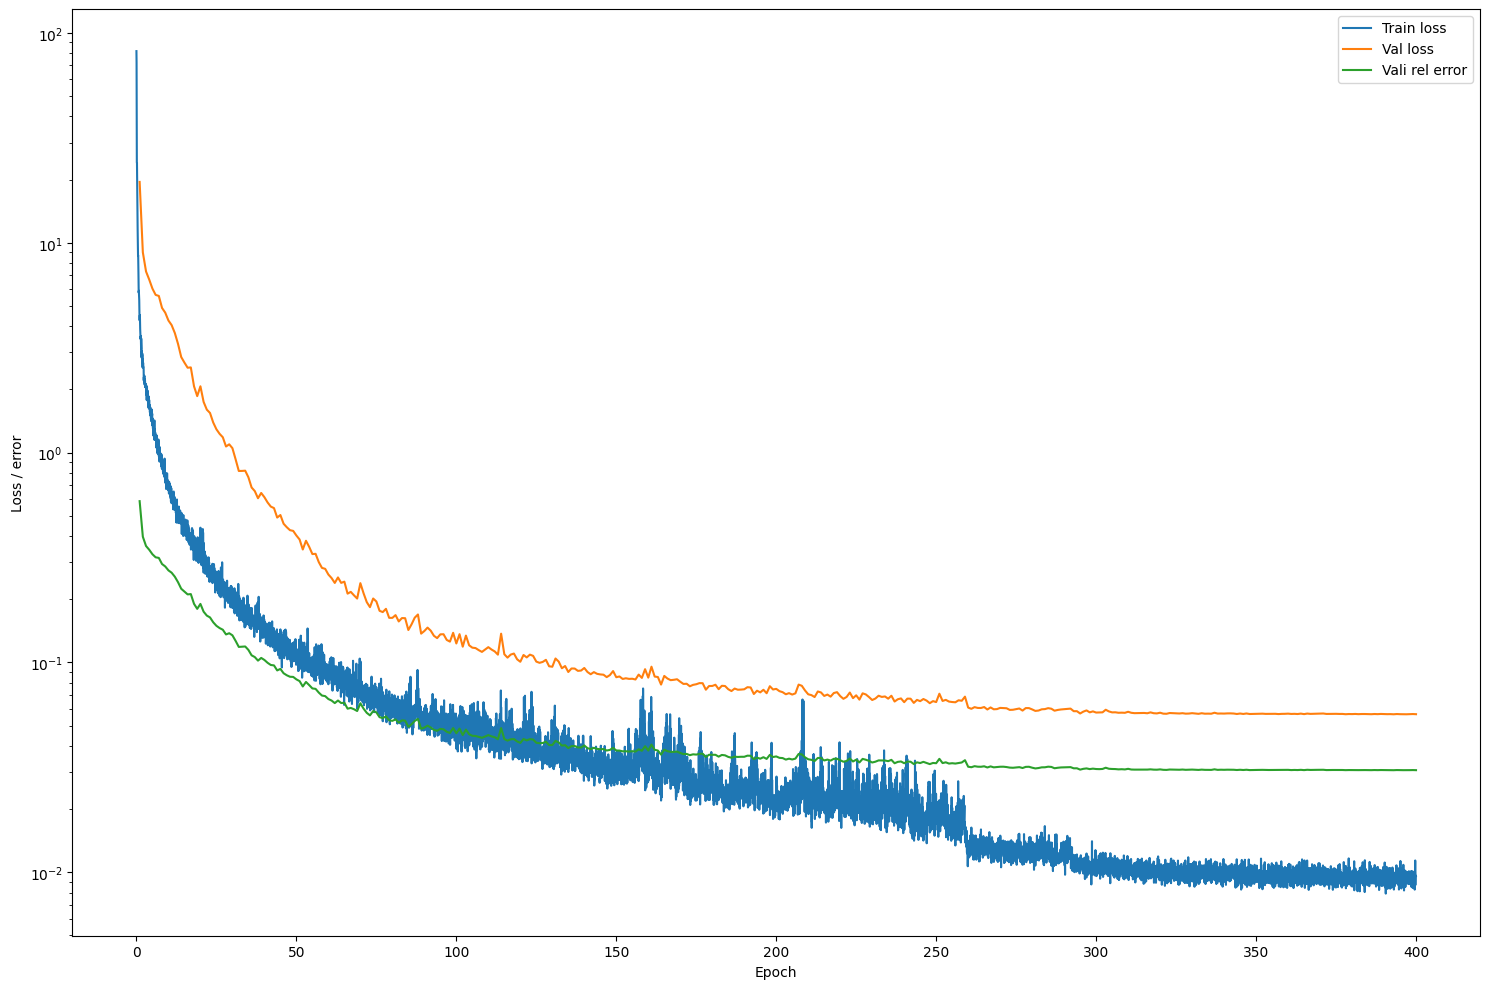

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), sharey=True)
plot(ax, train_loss_history, val_loss_history, val_rel_loss_history, num_epochs)
#ax.set_title(f"LR = {lr}")
plt.tight_layout()
plt.show()

In [ ]:
print(val_rel_loss_history[-1])

0.030638596950433195


After having optimized and bla bla bla we test the robustness of the best model with cross-validation


In [ ]:
def build_k_indices(N, k_fold, seed=52):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
    """
    interval = int(N / k_fold) #number of data per fold-set
    np.random.seed(seed)
    indices = np.random.permutation(N) #permutation of array from 0 to num_row
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

k_fold = 4
k_indices=build_k_indices(len(params), k_fold)

print(best_num_epochs, best_lr, batch_size, best_dim_reduced, best_L_enc_dec, len(params))

train_loss=[]
val_loss=[]
val_rel_loss=[]
for k in range (0, k_fold):
    test_vel_k=solutions["velocity"][k_indices[k,:]]
    train_params_k=params[np.delete(k_indices, k, axis=0).ravel()]
    train_vel_k=solutions["velocity"][np.delete(k_indices, k, axis=0).ravel()]
    test_params_k=params[k_indices[k]]

    test_vel_k=(test_vel_k - vel_space_min.to("cpu")*0.95) / (1.05*vel_space_max.to("cpu") - 0.95*vel_space_min.to("cpu"))
    train_vel_k=(train_vel_k - vel_space_min.to("cpu")*0.95) / (1.05*vel_space_max.to("cpu") - 0.95*vel_space_min.to("cpu"))
    train_params_k=(train_params_k-min_params)/(max_params-min_params)
    test_params_k=(test_params_k-min_params)/(max_params-min_params)

    print(len(test_vel_k),len(train_params_k), len(train_vel_k), len(test_params_k))

    model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_mlp_enc_history = run_vel_training_encoder_decoder(
        MLP_autoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec,),
        best_num_epochs, best_lr, batch_size, train_params_k, train_vel_k, test_params_k, test_vel_k, device, weights=[1,1]
    )
    # model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_mlp_enc_history = run_vel_training_encoder_decoder(
    #     MLP_autoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec,),
    #     best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, weights=[1,1]
    # )
    train_loss.append(train_loss_history[-1])
    val_loss.append(val_loss_history[-1])
    val_rel_loss.append(val_rel_loss_history[-1])
    print(val_rel_loss)
    # if k==0:
    #   break
    print(k)

mean_train_loss=sum(train_loss)/k_fold
mean_val_loss=sum(val_loss)/k_fold
mean_val_rel_loss=sum(val_rel_loss)/k_fold

print("The mean validation relative error after cross-validation is: ", mean_val_rel_loss)


300 0.001 64 128 3 1950
487 1461 1461 487
[0.02566075961447839]
0
487 1461 1461 487
[0.02566075961447839, 0.025586213908890678]
1
487 1461 1461 487
[0.02566075961447839, 0.025586213908890678, 0.02551689309505956]
2
487 1461 1461 487
[0.02566075961447839, 0.025586213908890678, 0.02551689309505956, 0.025624189533492134]
3
The mean validation relative error after cross-validation is:  0.02559701403798019


In [ ]:
print(val_rel_loss)

[0.024810375863766523, 0.02570325050510665, 0.025810648283674485, 0.026065137719226812]


In [ ]:
print(l,dim_reduced)

4 128


In [ ]:
def read_vtk(filename):
    """Read .vtk file and return the polydata"""

    fn_dir, fn_ext = os.path.splitext(filename)

    if fn_ext == '.vtk':
        reader = vtk.vtkPolyDataReader()
    elif fn_ext == '.vtp':
        reader = vtk.vtkXMLPolyDataReader()
    elif fn_ext == '.stl':
        reader = vtk.vtkSTLReader()
    elif fn_ext == '.obj':
        reader = vtk.vtkOBJReader()
    elif fn_ext == '.vtu':
        reader = vtk.vtkXMLUnstructuredGridReader()
    elif fn_ext == '.pvtu':
        reader = vtk.vtkXMLPUnstructuredGridReader()
    else:
        raise ValueError(F"File extension {fn_ext} not supported")

    reader.SetFileName(filename)
    reader.Update(0)
    mesh = reader.GetOutput()

    return mesh

def write_vtk(mesh, fn):
    """ Write a mesh (vtk polydata or unstructured grid) to disk """

    _, extension = os.path.splitext(fn)

    if extension == '.vtk':
        writer = vtk.vtkPolyDataWriter()
    elif extension == '.stl':
        writer = vtk.vtkSTLWriter()
    elif extension == '.vtp':
        writer = vtk.vtkXMLPolyDataWriter()
    elif extension == '.vtu':
        writer = vtk.vtkXMLUnstructuredGridWriter()
    elif extension == '.obj':
        writer = vtk.vtkOBJWriter()
    else:
        raise ValueError(f"Unrecognized extension {extension}")

    writer.SetInputData(mesh)
    writer.SetFileName(fn)
    writer.Update(0)
    writer.Write()

    return

def add_array(mesh, array, name):
    """Add numpy array as new field to a vtk file"""

    new_array = numpy_to_vtk(array)
    new_array.SetName(name)
    mesh.GetPointData().AddArray(new_array)

    return mesh

def compute_matching_idxs():
    """Compute correspondences bewteen indices on the .vtu and on the .mesh file for plotting"""

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10_ref.vtu'))
    points = vtk_to_numpy(mesh.GetPoints().GetData())

    mesh_2 = meshio.read(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries','bif_sym_alpha50_h0.10.mesh'))
    points_2 = mesh_2.points

    dist = cdist(mesh_2.points, points, metric='euclidean')

    idxs = np.argmin(dist, axis=0)

    return idxs


def visualize_solution(field_array, fields=None, step_t=10):
    """ Export the solution corresponding to the n-th snapshot (every step_t steps) to a .vtu file."""

    if fields is None:
        fields = {'velocity': 3, 'pressure': 1}  # fields and corresponding dimensions

    os.makedirs('solutions', exist_ok=True)

    idxs = compute_matching_idxs()

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10.vtu'))

    fom_solution = dict()
    for field in fields:
        # print(f"Processing field {field} - Dimension: {fields[field]}")
        cur_idxs = np.hstack([idxs + k * (Nh_space[field]//fields[field]) for k in range(fields[field])])
        fom_solution[field] = expand(field_array, basis_space[field], basis_time[field])[cur_idxs]
        print(fom_solution[field].shape)

    for cnt_t in range(0, Nh_time['velocity'], step_t):
        # print(f"\nProcessing timestep {cnt_t} of {Nh_time['velocity']}")
        for field in fields:
            cur_fom_solution = np.reshape(fom_solution[field][:, cnt_t], (fields[field], -1)).T
            mesh = add_array(mesh, cur_fom_solution, field)

        # write_vtk(mesh, os.path.join('solutions', f"solution_{n}_{cnt_t}" + '.vtu'))
        write_vtk(mesh, os.path.join('solutions', f"solution_{cnt_t}" + '.vtu'))

    return


In [ ]:
model_trained.eval()

input_tensor = torch.tensor(test_params[0,:], dtype=torch.float32)  # Trasforma in tensore
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor = input_tensor.to(device)  # Se usi la GPU

with torch.no_grad():
    output_visual = model_trained(input_tensor)
    output_visual=output_visual[0]
    print(output_visual.shape)

visualize_solution(output_visual.cpu().numpy() ,fields={'velocity': 3},step_t=5)

In [ ]:
!zip -r solutions.zip solutions
from google.colab import files
files.download('solutions.zip')